In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from get_utils import get_data, get_dir
import plot as plot
import matplotlib.pyplot as plt
#%matplotlib widget
#%matplotlib qt
%matplotlib inline

15.682898819961098
22.9517823270861
2.862772704903942
4.964702120914832
0.019475804959194924
6.659527907368245e-05
0.0002611411053055592
0.0
-3.4050711944313385
0.0029127904926711267


/Users/mahdiyar/miniconda3/envs/dl/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


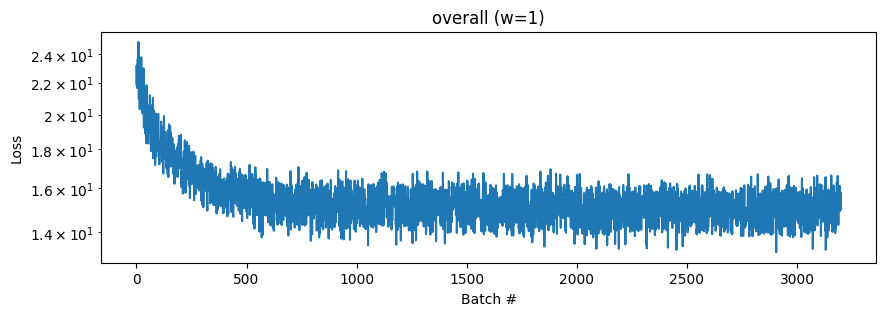

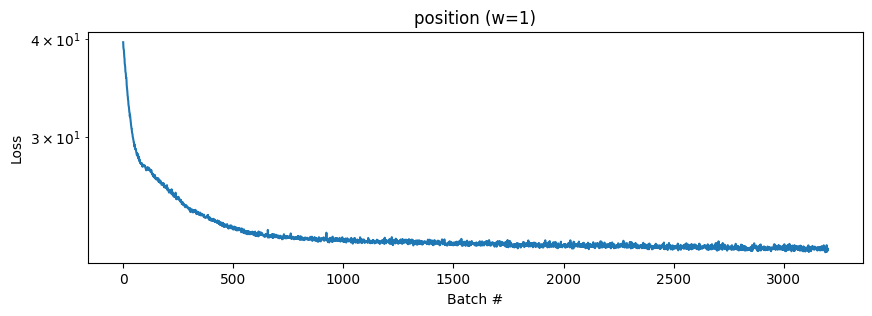

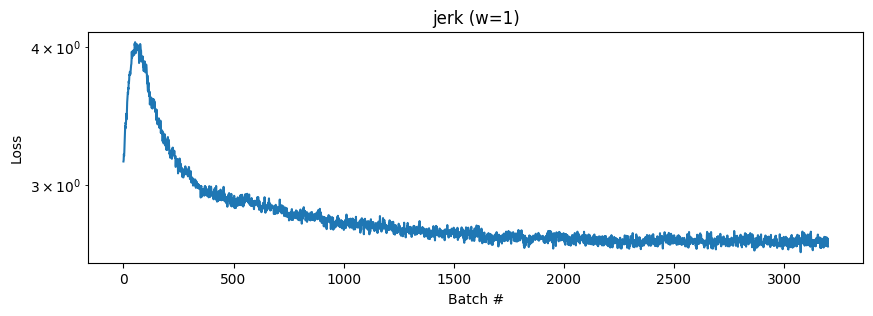

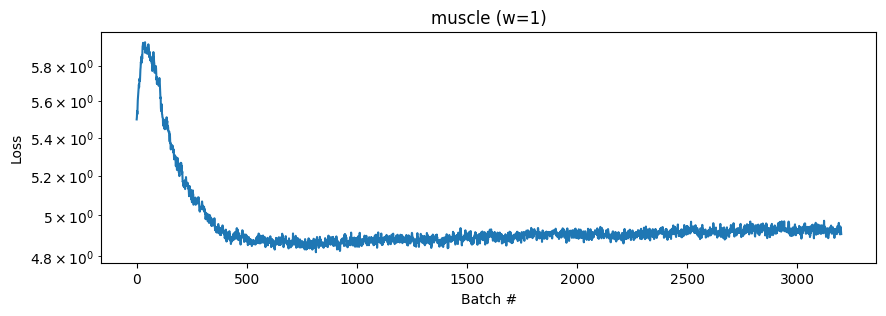

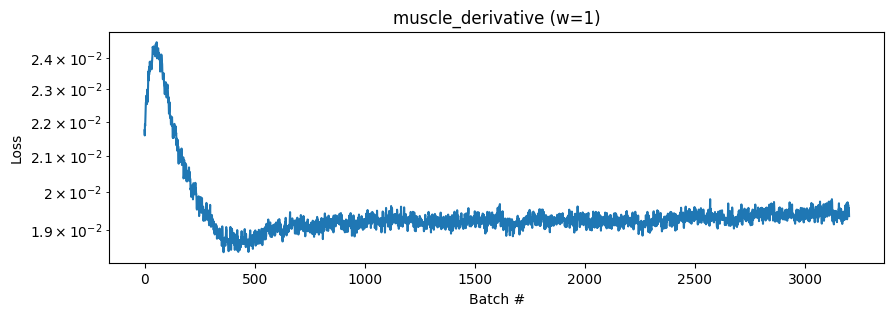

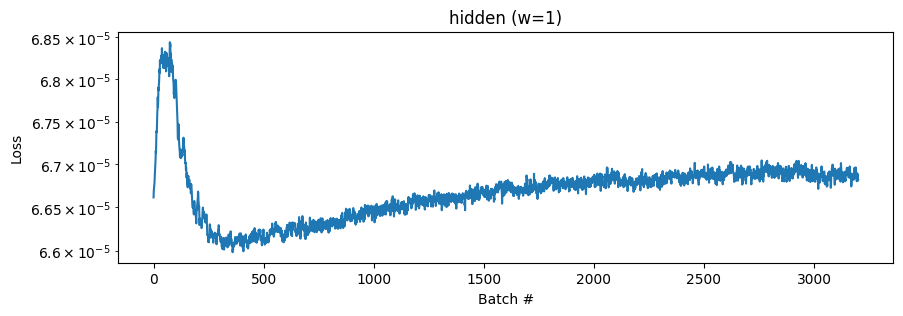

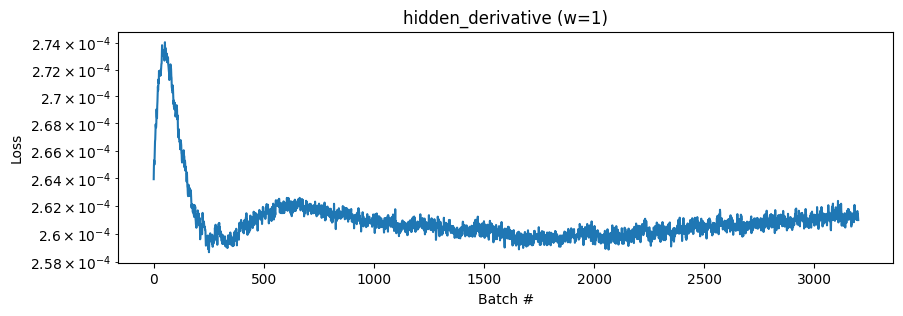

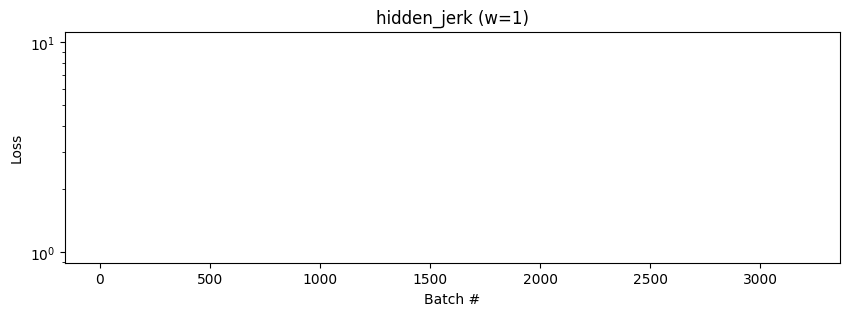

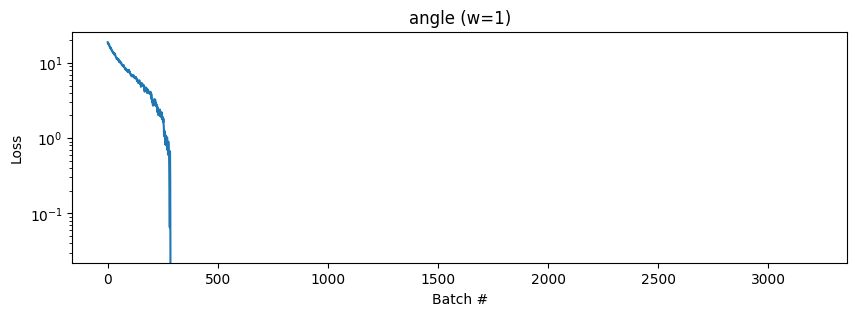

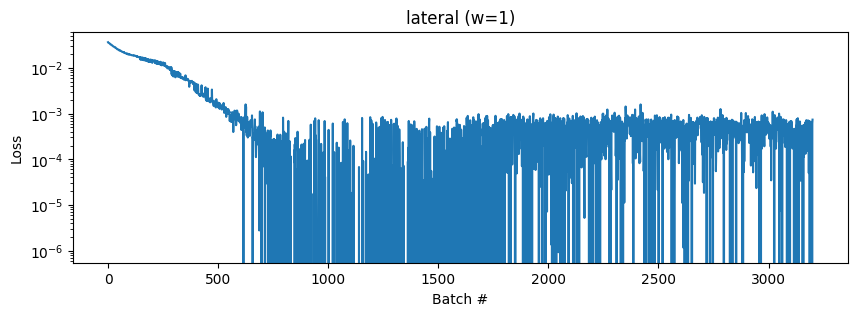

In [3]:
model_name = "model{:02d}".format(0)
phase = 'FF2'
ff_coef = 8
folder_name = 'Sim_simple_64'

_,_,loss_file = get_dir(folder_name, model_name, phase, ff_coef=ff_coef)
log = json.load(open(loss_file,'r'))
#log = log['0']
#len(log['0']['position'])

for loss in log.keys():
    fig,ax = plot.plot_training_log(log=log,loss_type=loss, w=1)
    ax.set_title(f"{loss} (w={1})")
#fig.savefig(os.path.join(data_dir,'loss_FF1.png'),dpi=300)

In [6]:
folder_name = 'Sim_simple_64'
num_hidden = 64
model_name = "model{:02d}".format(0)


phase = {'FF2':[8]}
ff_coef = None#[8,8]
data = get_data(folder_name,model_name,phase,ff_coef,is_channel=True,num_hidden=num_hidden)

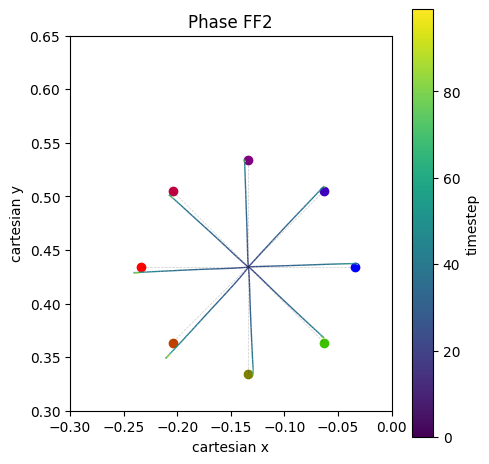

In [7]:
n_phase = len(phase)
fig,ax = plt.subplots(1,n_phase,figsize=(5*n_phase,5))
if len(phase) == 1:
    ax = [ax]
for i,p in enumerate(phase.keys()):
    plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    ax[i].set_title(f'Phase {p}')
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(data_dir,f'{model_name}_trajectory.png'),dpi=300)

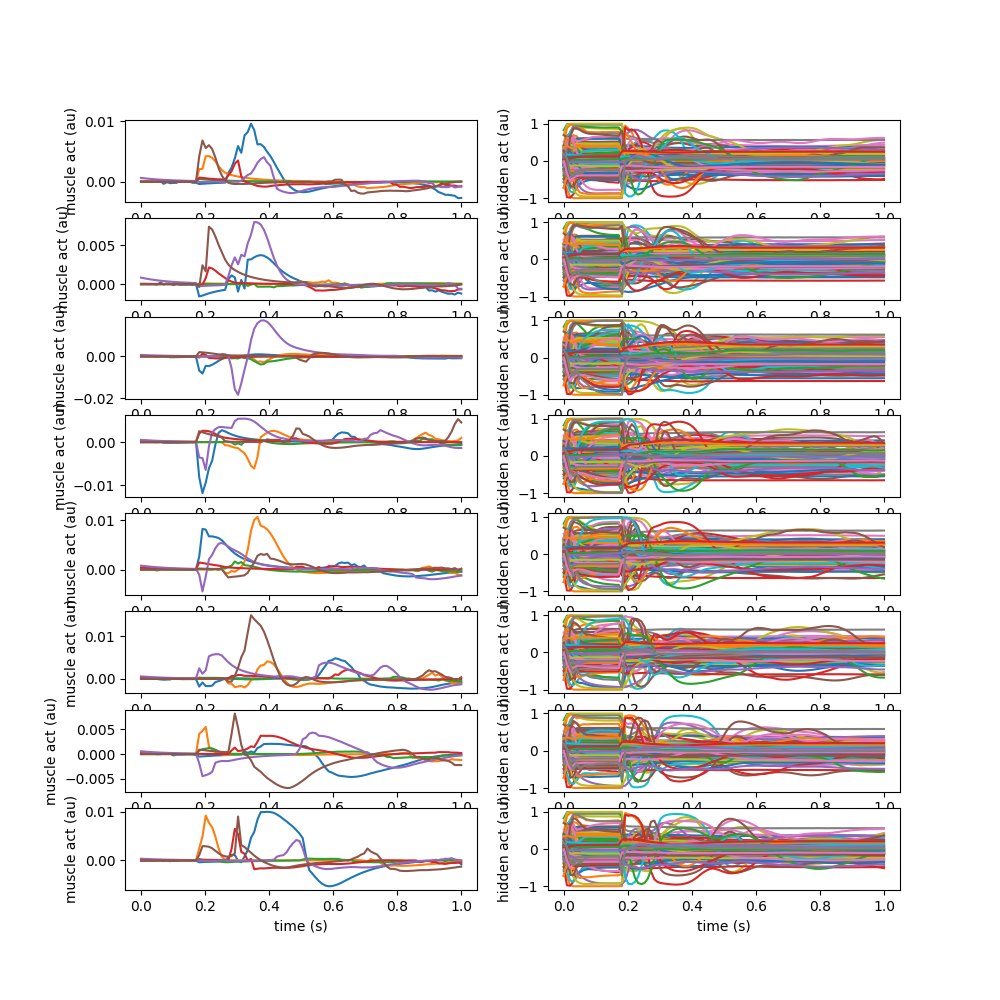

In [4]:
i=1
fig, ax = plot.plot_activation(data[1]['all_hidden'],data[3]['all_muscle']-data[1]['all_muscle'],figsize=(10,10))

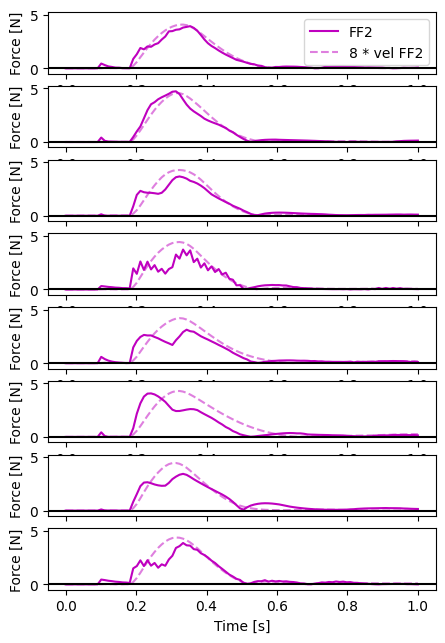

In [8]:
labels = list(phase.keys())
fig, ax = plot.plot_force(data,labels,figsize=(5,7.5))
#fig.savefig(os.path.join(data_dir,'lat_force.png'),dpi=300)

In [8]:
fig, ax = plot.plot_kinematic(data[i]['vel'],data[i]['xy'],data[i]['tg'],figsize=(10,7.5)) # data[i]['vel']
#fig.savefig(os.path.join(data_dir,'kinematic.png'),dpi=300)

In [9]:
labels = list(phase.keys())
fg, ax = plot.plot_epforce(data,labels,figsize=(5,15))